In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import norm
from math import sqrt
import EpiClockNBL.src.util as pc_util
nbl_consts = pc_util.consts

In [2]:
proj_dir = os.path.join(nbl_consts['official_indir'], 'TARGET')
c_beta_dir = os.path.join(nbl_consts['repo_dir'], 'Select_fCpGs', 'outputs')

In [3]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)


covar_path_outdir = os.path.join(figure_outdir, 'covar_path')
os.makedirs(covar_path_outdir, exist_ok=True)

In [4]:
clinical = {}

In [5]:
c_beta = pd.read_table(os.path.join(c_beta_dir, 'NBL.c_beta.txt'), index_col=0, header=None).squeeze('columns')
LUMP_purity = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0, header=None).squeeze('columns')

In [6]:
GMM_results_TARGET = pd.read_csv(os.path.join(nbl_consts['repo_dir'], 'Gaussian Mixture Model', 'TARGET.GMM_results.csv'), index_col=0)
GMM_results_TARGET.index = GMM_results_TARGET.index.map(lambda x:x.replace('.', '-'))

GMM_results_Henrich = pd.read_csv(os.path.join(nbl_consts['repo_dir'], 'Gaussian Mixture Model', 'Henrich.GMM_results.csv'), index_col=0)

In [7]:
GMM_results_TARGET_old = pd.read_csv(os.path.join(nbl_consts['repo_dir'], 'Gaussian Mixture Model', 'TARGET_tumor_params_GMM_summary.csv'), index_col=0)
GMM_results_TARGET_old.index = GMM_results_TARGET_old.index.map(lambda x:x.replace('.', '-'))

GMM_results_Henrich_old = pd.read_csv(os.path.join(nbl_consts['repo_dir'], 'Gaussian Mixture Model', 'Henrich_tumor_params_GMM_summary.csv'), index_col=0)

In [8]:
# Import TARGET clinical table
clinical['TARGET'] = pd.read_table(
    os.path.join(proj_dir, 'cohort1.clinical.tsv')
)
clinical['TARGET'] = clinical['TARGET'].set_index('submitter_id')

sampleIDs = c_beta.index.values
patient_to_sample_IDs = pd.Series(data=sampleIDs, index=[pc_util.sampleToPatientID(x) for x in sampleIDs]).rename('sampleID')
clinical['TARGET'] = clinical['TARGET'].merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

clinical['TARGET'] = clinical['TARGET'].merge(c_beta.rename('c_beta'), left_on='sampleID', right_index=True)
# clinical['TARGET'] = clinical['TARGET'].merge(c_beta_traditional.rename('c_beta_traditional'), left_on='sampleID', right_index=True)

clinical['TARGET'] = clinical['TARGET'].merge(LUMP_purity.rename('LUMP'), left_on='sampleID', right_index=True)

# Process certain columns
clinical['TARGET']['Age'] = clinical['TARGET']['age_at_diagnosis'] / 365
        
assert not clinical['TARGET']['Age'].astype(float).isna().any()
clinical['TARGET']['Age >= 1.5'] = (clinical['TARGET']['Age'] >= 1.5).map(lambda x:'Age >= 1.5 years' if x else 'Age < 1.5 years')
# clinical['TARGET']['Age >= 1.5'] = clinical['TARGET']['Age'].map(ageStratify)

# Reformat string
clinical['TARGET']['cog_neuroblastoma_risk_group'] = clinical['TARGET']['cog_neuroblastoma_risk_group'].map(lambda x:x.capitalize())

# Add GMM phi
clinical['TARGET'] = clinical['TARGET'].merge(GMM_results_TARGET['phi.mean'].rename('phi'), left_on='sampleID', right_index=True)

clinical['TARGET'].to_csv(os.path.join(proj_dir, 'clinical.annotated.tsv'), sep='\t')

In [9]:
# Import Henrich clinical table
clinical['Henrich'] = pd.read_table(
    os.path.join(nbl_consts['official_indir'], 'Henrich', 'sample_annotations_clean.txt'), index_col='Sample_geo_accession'
)

# Reformat strings
clinical['Henrich']['inss stage'] = 'Stage ' + clinical['Henrich']['inss stage'].astype(str)
clinical['Henrich']['inss stage'] = clinical['Henrich']['inss stage'].map(lambda x:'Stage 2' if x in['Stage 2.1', 'Stage 2.2'] else x)
clinical['Henrich']['age at diagnosis'] = clinical['Henrich']['age at diagnosis'].map({'>=1.5 years':'Age >= 1.5 years', '<1.5 years':'Age < 1.5 years'})
clinical['Henrich']['current risk category'] = clinical['Henrich']['current risk category'].map(lambda x:x.replace('-', ' ').capitalize())

# Add GMM phi
clinical['Henrich'] = clinical['Henrich'].merge(GMM_results_Henrich['phi.mean'].rename('phi'), left_index=True, right_index=True)

In [10]:
print(pc_util.getCorrelation(clinical['TARGET'], 'phi', 'LUMP'))
print(pc_util.getCorrelation(clinical['TARGET'], 'Age', 'c_beta'))
print(pc_util.getCorrelation(clinical['TARGET'], 'Age', 'c_beta', use_samples=clinical['TARGET'].index[clinical['TARGET']['Age'] < 7.5]))

LinregressResult(slope=-0.4891897291839833, intercept=0.8486504092408691, rvalue=-0.274362118662765, pvalue=4.9329655454698975e-05, stderr=0.11803705206865005, intercept_stderr=0.0932162425590263)
LinregressResult(slope=-25.02297586090816, intercept=23.64436723261131, rvalue=-0.29508221146698665, pvalue=1.1914448581948327e-05, stderr=5.577924144142056, intercept_stderr=4.542942346141986)
LinregressResult(slope=-12.70881558644552, intercept=13.137096982652974, rvalue=-0.2414891198049145, pvalue=0.0005355975521489083, stderr=3.611144588589838, intercept_stderr=2.94687530824401)


## Check convergence statistics

In [28]:
TARGET_Rhat = GMM_results_TARGET.loc[:, GMM_results_TARGET.columns.str.endswith('.Rhat')]
print(f'Rhat range in TARGET: ({TARGET_Rhat.min().min():.3f}, {TARGET_Rhat.max().max():.3f})')

TARGET_n_eff = GMM_results_TARGET.loc[:, GMM_results_TARGET.columns.str.endswith('n_eff')]
print(f'ESS range in TARGET: ({TARGET_n_eff.min().min():.0f}, {TARGET_n_eff.max().max():.0f})')

Rhat range in TARGET: (1.000, 1.014)
ESS range in TARGET: (363, 7473)


In [29]:
Henrich_Rhat = GMM_results_Henrich.loc[:, GMM_results_Henrich.columns.str.endswith('.Rhat')]
print(f'Rhat range in Henrich: ({Henrich_Rhat.min().min():.3f}, {Henrich_Rhat.max().max():.3f})')

Henrich_n_eff = GMM_results_Henrich.loc[:, GMM_results_Henrich.columns.str.endswith('n_eff')]
print(f'ESS range in Henrich: ({Henrich_n_eff.min().min():.0f}, {Henrich_n_eff.max().max():.0f})')

Rhat range in Henrich: (1.000, 1.004)
ESS range in Henrich: (1914, 7351)


## Make Figures

In [30]:
## Configure graph
sf = nbl_consts['sf']
figsize = np.array([7, 4])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [31]:
# ## Must set dataframe names for use of saveBoxPlotNew and saveCorrelationPlot

clinical['TARGET'].name = 'Discovery'
clinical['Henrich'].name = 'Validation'

### 3 example tumors

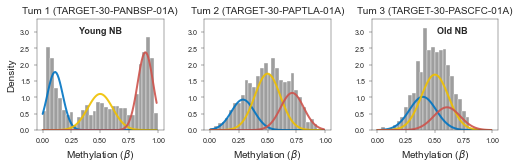

In [119]:
## Plot beta value distriubtions for 3 example tumors

beta_values_Clock = pd.read_table(
    os.path.join(nbl_consts['official_indir'], 'TARGET', 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv'),
    index_col=0)

sample_list = {
    # 'Tum1':'TARGET-30-PANUKV-01A',
    'Tum 1':'TARGET-30-PANBSP-01A',
    'Tum 2':'TARGET-30-PAPTLA-01A',
    'Tum 3':'TARGET-30-PASCFC-01A'
}

# Create plot axes
fig, axes = plt.subplots(1, len(sample_list), figsize=np.array(figsize) * [2.5, 1.2] * sf)
fig.tight_layout(pad=0.2)

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [nbl_consts['palette_jco'][i] for i in [0, 1, 3]]

# X coordinates for curves
x_vals = np.linspace(0, 0.99, 100)

for i, tum_id in enumerate(sample_list):
    ax = axes[i]
    samp = sample_list[tum_id]
    patient = pc_util.sampleToPatientID(samp)
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=nbl_consts['palette_jco'][2],
                 bins=30, alpha=nbl_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{tum_id} ({samp})', fontsize=nbl_consts['labelfontsize'] * sf)
    ax.set_xlabel(r'Methylation ($\beta$)', fontsize=nbl_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=nbl_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Weight of each of three distributions
    weight_list = GMM_results_TARGET.loc[samp, ['psi[1].mean', 'psi[2].mean', 'psi[3].mean']]
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    X_mean = GMM_results_TARGET.loc[samp, 'X.mean']
    N_mean = GMM_results_TARGET.loc[samp, 'N.mean']
    mu_list = [X_mean, 0.5, 1 - X_mean]
    sd_list = [sqrt(mu * (1 - mu) / N_mean) for mu in mu_list]
    
    # Plot each distribution
    for j in range(weight_list.shape[0]):

        # X and Y coords for curve
        y_vals = norm.pdf(x_vals, mu_list[j], sd_list[j]) * weight_list[j]
        
        # Plot curve
        ax.plot(x_vals, y_vals, lw=2, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        # Update max
        y_max = max(y_max, ax.get_ylim()[1])
    
#     y_vals_kernel = np.stack([norm.pdf(x_vals, mu_list[j], sd_list[j]) * weight_list[j] for j in range(weight_list.shape[0])], axis=0).sum(axis=0)
#     ax.plot(x_vals, y_vals_kernel, lw=1, alpha=0.9, color='gray')
    
# Align y-axis limits
for i in range(len(sample_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

for i, text, x_pos in zip([0, 2], ['Young NB', 'Old NB'], [0.5, 0.65]):
    axes[i].text(x_pos, y_max * 0.9,
            text,
                 # color='Black',
            ha="center", fontfamily='sans-serif', fontsize=0.9 * nbl_consts['labelfontsize'] * sf, fontweight='bold',
                 # alpha=nbl_consts['opacity']
           )

# Save figure
file_format = 'svg'
fig.savefig(os.path.join(figure_outdir, f'example_peak_decomp.{file_format}'), format=file_format, pad_inches=0.1)

# Tumor mitotic age distribution

## Histogram

KeyError: 'Tum1'

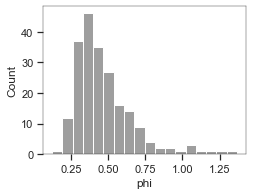

In [120]:
plot_data = clinical['TARGET'].loc[clinical['TARGET']['in_analysis_dataset'], 'phi']

# Create plot
fig, ax = plt.subplots(figsize=figsize * [1.3, 1.7] * sf)
sns.histplot(ax=ax, x=plot_data,
             color=nbl_consts['palette_jco'][2], alpha=nbl_consts['opacity'])

# Mark (with vertical lines) the c_beta values of three
#   example tumors from plot in the previous cell
line_color = 'black'
tumor_heights = [0.8, 0.8, 0.8]

x_0 = clinical['TARGET'].loc[pc_util.sampleToPatientID(sample_list['Tum1']), 'phi']
x_1 = clinical['TARGET'].loc[pc_util.sampleToPatientID(sample_list['Tum2']), 'phi']
x_2 = clinical['TARGET'].loc[pc_util.sampleToPatientID(sample_list['Tum3']), 'phi']

ax.axvline(x=x_0, ymax=tumor_heights[0], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_1, ymax=tumor_heights[1], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_2, ymax=tumor_heights[2], lw=2.5 * sf, color=line_color)

# Customize figure
ax.set_xlabel('Tumor mitotic age', fontsize=nbl_consts['labelfontsize']*sf)
ax.set_ylabel('Count', fontsize=nbl_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_ylim(top=75)

# Widen plot a little
xlim = ax.get_xlim()
width = xlim[1] - xlim[0]
ax.set_xlim(left = xlim[0] - width/20)

# Annotate the vertical lines with text for all 3 tumors
y_height = ax.get_ylim()[1]

ax.text(x_0, (tumor_heights[0]+0.05)*y_height,
        'Tum1', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * nbl_consts['labelfontsize'] * sf, alpha=nbl_consts['opacity']
       )
ax.text(x_1, (tumor_heights[1]+0.05)*y_height,
        'Tum2', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * nbl_consts['labelfontsize'] * sf, alpha=nbl_consts['opacity']
       )
ax.text(x_2-0.005, (tumor_heights[2]+0.05)*y_height,
        'Tum3', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * nbl_consts['labelfontsize'] * sf, alpha=nbl_consts['opacity']
       )

# Save figure
file_format = 'svg'
fig.savefig(os.path.join(figure_outdir, f'mitotic_age_distribution.{file_format}'), format=file_format, pad_inches=0.1)

## Beeswarm

In [121]:
sample_list_inverse = dict(map(lambda x:x[::-1], list(sample_list.items())))
clinical['TARGET']['TumLabeled'] = clinical['TARGET']['sampleID'].map(sample_list_inverse).fillna('Others')

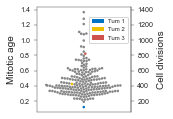

In [124]:
mu_manual_est = 1e-3
clinical['TARGET']['divisions'] = clinical['TARGET']['phi'] / mu_manual_est

# Create plot
fig, ax = plt.subplots(figsize=figsize * [1 * 0.6, 1.2] * sf)
# point_size = 15
point_size = 16

#########################################
########### Mitotic age (phi) ###########
#########################################

jco = nbl_consts['palette_jco']
color_dict = dict(zip(['Others', 'Tum 1', 'Tum 2', 'Tum 3'], [jco[2], jco[0], jco[1], jco[3]]))

sns.swarmplot(ax=ax, data=clinical['TARGET'],
              y='phi',
              palette=color_dict,
              hue='TumLabeled',
              legend=False,
             s=point_size * sf**2)

# Customize figure
ax.set_xlabel('')
ax.set_ylabel('Mitotic age', fontsize=nbl_consts['labelfontsize'] * sf)
ax.set_xticks([])
# ax.tick_params(axis='x', labelsize=nbl_consts['labelfontsize'] * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)


def secondYaxisFunc(x):
    return x / mu_manual_est
def secondYaxisFunc_INV(x):
    return x * mu_manual_est
    
second_yaxis = ax.secondary_yaxis('right', functions=(secondYaxisFunc, secondYaxisFunc_INV))
second_yaxis.set_ylabel('Cell divisions', fontsize=nbl_consts['labelfontsize'] * sf)
second_yaxis.tick_params(axis='y', labelsize=nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Legend
patches = [
    # Line2D([0], [0], color=color_dict[group], linewidth=2*sf, label=group)
    mpatches.Patch(
        color=color_dict[group], label=group, alpha=1, lw=0
    )
                   for group in [f'Tum {i}' for i in range(1, 4)]]

# mpatches.Patch(color=nbl_consts['palette_jco'][2], alpha=0.2, lw=0,
#                            # label='Screening period'
#                            label='Infancy'
#                           )

plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y * 0.95),
           fontsize= 0.6 * nbl_consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'mitotic_age_divisions_beeswarm.svg'), format='svg', pad_inches=0.1)

# Covariate Analysis

In [20]:
clinical['TARGET']['inss_stage'].value_counts()

Stage 4     167
Stage 4S     24
Stage 1      15
Stage 3       6
Stage 2B      1
Name: inss_stage, dtype: int64

<Axes: xlabel='gender', ylabel='Tumor mitotic age'>

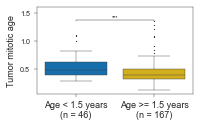

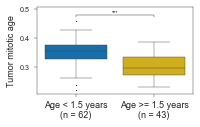

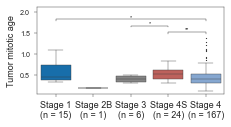

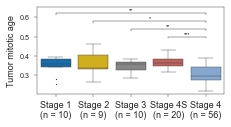

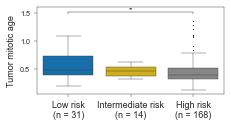

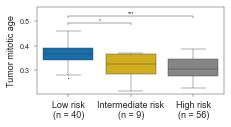

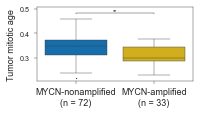

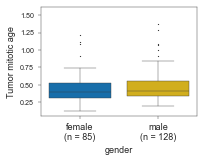

In [23]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'Age >= 1.5', restrict=True,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.02,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, file_format='svg',
                   figsize=figsize, labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'age at diagnosis', restrict=False,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.02,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, file_format='svg',
                   figsize=figsize, labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'inss_stage', restrict=True,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.15,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age', file_format='svg',
                       outdir=covar_path_outdir, use_groups=['Stage 1', 'Stage 2B', 'Stage 3', 'Stage 4S', 'Stage 4'],
                   figsize=figsize * [1.2, 1], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'inss stage', restrict=False,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.04,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age', file_format='svg',
                       outdir=covar_path_outdir, use_groups=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4S', 'Stage 4'],
                   figsize=figsize * [1.2, 1], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'cog_neuroblastoma_risk_group', restrict=True,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.15,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age', file_format='svg',
                       outdir=covar_path_outdir, use_groups=["Low risk", "Intermediate risk", "High risk"],
                   figsize=figsize * [1.2, 1], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'current risk category', restrict=False,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.03,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age', file_format='svg',
                       outdir=covar_path_outdir, use_groups=["Low risk", "Intermediate risk", "High risk"],
                   figsize=figsize * [1.2, 1], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'mycn status', restrict=False,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.023,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age', file_format='svg',
                       outdir=covar_path_outdir, use_groups=['MYCN-nonamplified', 'MYCN-amplified'],
                   figsize=figsize * [1, 0.85], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])


pc_util.saveBoxPlotNew(clinical['TARGET'], 'gender', restrict=False,
                   var_y='phi', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=nbl_consts['palette_jco'], xlabel='gender', ylabel='Tumor mitotic age', file_format='svg',
                   figsize=np.array([7, 5]), labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

In [35]:
def getVarMeans(col):
    return clinical['TARGET'].groupby(col)['phi'].agg(['count', 'mean']).sort_values('count', ascending=False)

<Axes: title={'center': 'c_beta by Race'}, xlabel='race_3cat', ylabel='$c_β$'>

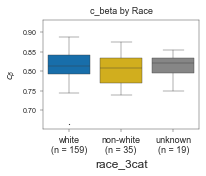

In [36]:
def map_race_to_3cat(race_value):
    """
    Convert each race entry into 'white', 'nonwhite', or 'unknown'.
    """
    if pd.isna(race_value) or str(race_value).lower() == 'unknown':
        return 'unknown'
    elif str(race_value).lower() == 'white':
        return 'white'
    else:
        return 'non-white'

# Apply this mapping to your 'race' column
clinical['TARGET']['race_3cat'] = clinical['TARGET']['race'].apply(map_race_to_3cat)

# Option A: Make it a categorical with the correct order
cat_order = ['white', 'non-white', 'unknown']
clinical['TARGET']['race_3cat'] = pd.Categorical(
    clinical['TARGET']['race_3cat'],
    categories=cat_order,
    ordered=True
)

pc_util.saveBoxPlotNew(
    sample_annotations = clinical['TARGET'],
    var_cat           = 'race_3cat',
    var_y             = 'c_beta',
    restrict          = False,
    use_groups        = cat_order,
    outdir            = '.',
    outfile           = False,
    title             = False,
    custom_title      = 'c_beta by Race',
    palette           = nbl_consts['palette_jco'],
    xlabel            = 'Race',
    figsize           = np.array([7, 5]),
    labelfontsize     = nbl_consts['labelfontsize'] * 0.9,
    ticksfontsize     = nbl_consts['ticksfontsize'],
    sf                = sf,
    linewidth         = nbl_consts['linewidth'],
    fliersize         = nbl_consts['fliersize']
)


## Estimate calendar ages

In [37]:
MIN_DAYS_BEFORE_BIRTH = 40 * 7

### Mean method

In [38]:
# dataset = 'TARGET'

# age_day_limit = 80
# young_tumors = clinical[dataset].index[clinical[dataset]['age_at_diagnosis'] <= age_day_limit]

# print(f'Using {young_tumors.shape[0]} tumors to estimate alpha * mu')

# approx_avg_calAge = clinical[dataset].loc[young_tumors]['age_at_diagnosis'].mean() + 6*30
# alpha_mu = clinical[dataset].loc[young_tumors]['phi'].mean() / approx_avg_calAge

### Min method

In [72]:
0.0042 / .17

0.024705882352941175

Chose alpha * mu = 0.0042
Minimum tumor initiation time is estimated to be -179.99


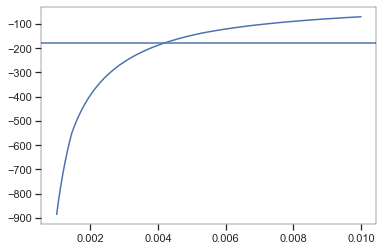

In [73]:
dataset = 'TARGET'
MIN_INITIATION_TIME = -180
age_day_limit = 80

# Determine alpha * mu value such that the the minimum initiation time is -180 days
alpha_mu_vals = np.linspace(1e-3, 1e-2, 10000)
min_tumor_init_time_vals = []
# young_tumors = clinical[dataset].index[clinical[dataset]['age_at_diagnosis'] <= age_day_limit]
young_tumors = clinical[dataset].index
for alpha_mu_i in alpha_mu_vals:
    # Initation is patient age
    initiation_times = clinical[dataset].loc[young_tumors]['age_at_diagnosis'] - clinical[dataset].loc[young_tumors]['phi'] / alpha_mu_i
    min_tumor_init_time_vals.append(
        np.min(initiation_times)
    )

sns.lineplot(x=alpha_mu_vals, y=min_tumor_init_time_vals)
plt.axhline(y=MIN_INITIATION_TIME)

min_tumor_init_time_vals = np.array(min_tumor_init_time_vals)
min_idx = np.argmin(np.abs(min_tumor_init_time_vals - MIN_INITIATION_TIME))

# Choose ideal value of alpha * mu
alpha_mu = alpha_mu_vals[min_idx]
print(f'Chose alpha * mu = {alpha_mu:.4f}')
print(f'Minimum tumor initiation time is estimated to be {min_tumor_init_time_vals[min_idx]:.2f}')

## Waterfall plot

In [103]:
# clinical['TARGET'] = pd.read_csv('/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/0. PAPER/2. Figures/forDan.csv', index_col=0)
clinical['TARGET']['Stage 4'] = (clinical['TARGET']['inss_stage'] == 'Stage 4').map(lambda x:'Stage 4' if x else 'Stage 1, 3, or 4S')
clinical['TARGET']['calendar_age'] = clinical['TARGET']['phi'] / alpha_mu

# Cannot be older than the patient plus 280 days (pregnancy)
# clinical['TARGET']['calendar_age'] =  pd.concat(
#     [clinical['TARGET']['calendar_age'],
#      clinical['TARGET']['age_at_diagnosis'] + MIN_DAYS_BEFORE_BIRTH], 
#     axis=1
# ).min(axis=1)

# Convert to years
clinical['TARGET']['calendar_age_years'] = clinical['TARGET']['calendar_age'] / 365

color_var = 'Stage 4'
color_dict = dict(zip(clinical['TARGET'][color_var].unique(), [nbl_consts['palette_jco'][3], nbl_consts['palette_jco'][4]]))

PREGNANCY_LENGTH = 40 * 7

def swimmersPlot(fig, ax, tumors_chosen, legend=True, xlabel=True, xlim_left=-1.5, y_extra=4):
#     fig, ax = plt.subplots(figsize=np.array(figsize) * sf)
    tumors_ordered = clinical['TARGET'].loc[tumors_chosen].sort_values('Age').index

    for i, tum in enumerate(tumors_ordered):
        x_points = [clinical['TARGET'].loc[tum, 'Age'] - clinical['TARGET'].loc[tum, 'calendar_age_years'], clinical['TARGET'].loc[tum, 'Age']]
        y_points = [i, i]
        color = color_dict[clinical['TARGET'].loc[tum, color_var]]

        # Plot the circle on the left side
        ax.plot(x_points[0], y_points[0], 'o', markersize=4*sf, color=color)  # green circle

        shrink = 0
        arrow = mpatches.FancyArrowPatch((x_points[0], y_points[0]), (x_points[1], y_points[1]),
                                         arrowstyle='-|>', color=color,
                                         linewidth=2*sf, mutation_scale=12*sf,
                                         shrinkA=shrink, shrinkB=shrink)
        ax.add_patch(arrow)    

    if legend:
        # Main legend
        patches_main = [Line2D([0], [0], color=color_dict[group], linewidth=2*sf, label=group)
                   for group in color_dict.keys()]
        # plots_x, plots_y = ax.get_position().get_points()[1]
        # fig.legend(handles=patches,
        #            loc='upper right',
        #            bbox_to_anchor=(plots_x, plots_y * 0.95),
        #            fontsize= 1.2 * nbl_consts['labelfontsize'] * sf
        #           )
        
        # Line/shading legend
        patches = [
            Line2D([0], [0],
                   color=nbl_consts['palette_jco'][2],
                   linestyle='--', linewidth=3*sf,
                   label='Conception'),
            mpatches.Patch(color=nbl_consts['palette_jco'][2], alpha=0.2, lw=0,
                           # label='Screening period'
                           label='Infancy'
                          )
        ][::-1]
        patches.extend(patches_main)
        
        fig.legend(handles=patches[::-1],
                   loc='upper right',
                   # bbox_to_anchor=(plots_x, plots_y * 0.22),
                   bbox_to_anchor=(plots_x * 0.99, plots_y * 0.275),
                   fontsize= 1.2 * nbl_consts['labelfontsize'] * sf
                  )

    if xlabel:
        ax.set_xlabel('Patient age (years)', fontsize= 1.6 * nbl_consts['labelfontsize']*sf)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
    ax.tick_params(axis='x', labelsize= 1.2 * nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

#     ax.axvline(x=0, color=nbl_consts['palette_jco'][2], linestyle='--', linewidth=3*sf)
    ax.axvline(x= - PREGNANCY_LENGTH / 365,
               color=nbl_consts['palette_jco'][2], linestyle='--', linewidth=3*sf)


    ax.set_xlim(left=xlim_left, right=clinical['TARGET'].loc[tumors_chosen, 'Age'].max())

    bottom = -y_extra
    top = len(tumors_ordered) + y_extra
    ax.set_ylim(bottom, top)
    ax.fill([0, 1, 1, 0], [bottom, bottom, top, top],
            color=nbl_consts['palette_jco'][2], alpha=0.2, lw=0)

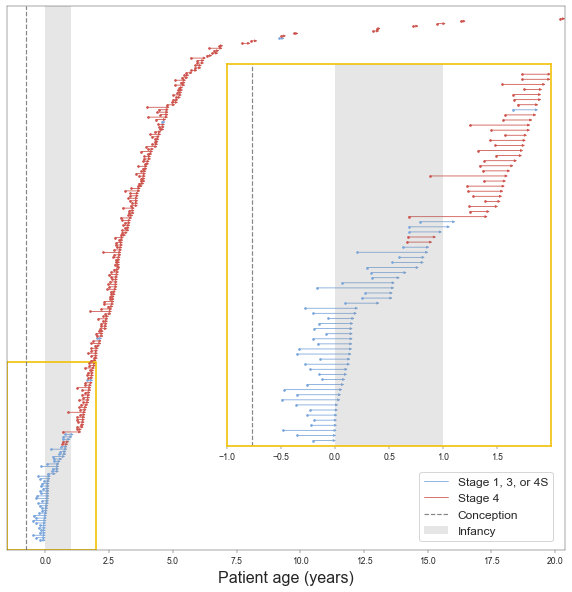

In [104]:
all_patients = clinical['TARGET'].index[clinical['TARGET']['in_analysis_dataset']]

fig, ax = plt.subplots(figsize=np.array((25, 25)) * sf)
xlim_left = -1.5
y_extra = 4
swimmersPlot(fig, ax, all_patients, xlim_left=xlim_left, y_extra=y_extra)

# figsize_young = np.array([
#     25 * (clinical['TARGET'].loc[patients_younger_2_5_years, 'Age'].max() - (-1.5)) / (clinical['TARGET'].loc[all_patients, 'Age'].max() - (-1.5)),
#     25 * (patients_younger_2_5_years.shape[0] - (-4)) / (all_patients.shape[0] - (-4))
# ])

# Overlay blown-up plot
years_thresh = 2.0
# ax2 = fig.add_axes([0.4, 0.23, 0.45, 0.53])
ax2 = fig.add_axes([0.43, 0.27, 0.45, 0.53])
patients_younger_2_years = clinical['TARGET'].index[clinical['TARGET']['in_analysis_dataset'] & (clinical['TARGET']['Age'] <= years_thresh)]
swimmersPlot(fig, ax2, patients_younger_2_years, legend=False, xlabel=False, xlim_left=-1, y_extra=1)
for spine in ax2.spines.values():
    spine.set_edgecolor(nbl_consts['palette_jco'][1])
    spine.set_linewidth(4 * sf)

ax.add_patch(
    mpatches.Rectangle((years_thresh, -y_extra), width=-years_thresh + xlim_left, height=y_extra + patients_younger_2_years.shape[0] - 0.5,
                         linewidth=4 * sf, edgecolor=nbl_consts['palette_jco'][1], facecolor='none')
)

# Save figure
file_format = 'svg'
fig.savefig(os.path.join(figure_outdir, f'swimmer_plot.{file_format}'), format=file_format, pad_inches=0.1)

## Statistics

In [82]:
cl = clinical['TARGET']
cl['Initiation Age'] = cl['Age'] - cl['calendar_age_years']
cl['Initiated after 1 year'] = cl['Initiation Age'] > 1
cl['Good outcome stage'] = cl['inss_stage'] != 'Stage 4'

### (i)

In [77]:
cl_after15 = cl.loc[cl['Age'] > 1.5]
print('Tumors detected after 1.5 years of age\n')

print(f'Min age at tumor initiation: {cl_after15["Initiation Age"].min():.2f} yrs')
print(f'# tumors total: {cl_after15["Initiation Age"].shape[0]}')
print(f'# tumors initiated after 1 year of age: {cl_after15["Initiated after 1 year"].sum()}')
print(f'Percent of tumors initiated after 1 year of age: {cl_after15["Initiated after 1 year"].mean() * 100:.2f}')

Tumors detected after 1.5 years of age

Min age at tumor initiation: 0.88 yrs
# tumors total: 167
# tumors initiated after 1 year of age: 166
Percent of tumors initiated after 1 year of age: 99.40


### (ii)

In [79]:
cl['inss_stage'].value_counts()

Stage 4     167
Stage 4S     24
Stage 1      15
Stage 3       6
Stage 2B      1
Name: inss_stage, dtype: int64

In [83]:
display(cl.groupby('Good outcome stage')['Initiated after 1 year'].agg(['sum', 'mean']))

print('Good outcome stage counts:')
display(cl['Good outcome stage'].value_counts())

,sum,mean
Good outcome stage,,
False,163,0.976048
True,4,0.086957


Good outcome stage counts:


False    167
True      46
Name: Good outcome stage, dtype: int64

In [81]:
42/46

0.9130434782608695

### (iii)

In [95]:
print('Mean sojourn times (calendar age in days)\n')

display(cl.groupby('inss_stage')['calendar_age'].agg(['mean', 'min', 'max']))
print()
display(cl.groupby('Good outcome stage')['calendar_age'].agg(['mean', 'min', 'max']))

from scipy.stats import ttest_ind
ttest_res = ttest_ind(
    cl.loc[cl['Good outcome stage'], 'calendar_age'],
    cl.loc[~cl['Good outcome stage'], 'calendar_age']
)
print(f'T-test, P = {ttest_res.pvalue:.3f}')

Mean sojourn times (calendar age in days)



,mean,min,max
inss_stage,,,
Stage 1,135.783126,80.030853,261.597507
Stage 2B,46.007478,46.007478,46.007478
Stage 3,99.070893,76.575217,119.874467
Stage 4,108.484925,29.186788,329.281940
Stage 4S,130.540571,77.221429,197.988636


,mean,min,max
Good outcome stage,,,
False,108.484925,29.186788,329.281940
True,126.307683,46.007478,261.597507


T-test, P = 0.026


In [93]:
ttest_ind

Help on function ttest_ind in module scipy.stats._stats_py:

ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
    Calculate the T-test for the means of *two independent* samples of scores.
    
    This is a test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.
    
    Parameters
    ----------
    a, b : array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int or None, optional
        Axis along which to compute test. If None, compute over the whole
        arrays, `a`, and `b`.
    equal_var : bool, optional
        If True (default), perform a standard independent 2 sample test
        that assumes equal population variances [1]_.
        If False, perform Welch's t-test, which

# Clinical supplements

In [25]:
clinical_survival = pd.read_table(os.path.join(nbl_consts['official_indir'], 'TARGET', 'clinical.annotated.survival.tsv'), index_col=0)

In [26]:
supp1 = pd.read_excel('/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/Datasets/TARGET/gdc_data/TARGET-NBL/harmonized/Clinical/Clinical_Supplement/cdb0d02c-43d0-4d50-931d-ec2dbdf71a24/TARGET_NBL_ClinicalData_Validation_20230322.xlsx',
                     sheet_name='Clinical Data', index_col=0)
supp2 = pd.read_excel('/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/Datasets/TARGET/gdc_data/TARGET-NBL/harmonized/Clinical/Clinical_Supplement/f5bfc8a5-b903-4418-b633-62234388a635/TARGET_NBL_ClinicalData_Discovery_20230523.xlsx',
                     sheet_name='Clinical Data', index_col=0)

/Users/danielmonyak/miniforge3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/danielmonyak/miniforge3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Exlore sample set

In [27]:
print(supp1.shape)
print(supp2.shape)

print(np.intersect1d(supp1.index, supp2.index).shape)
print(np.unique(np.concatenate([supp1.index, supp2.index])).shape) # 842 is the total number of TARGET-NBL patients
print((supp1.columns == supp2.columns).all())

(499, 30)
(343, 30)
(0,)
(842,)
True


In [28]:
print(np.intersect1d(clinical['TARGET'].index, supp1.index).shape)
print(np.intersect1d(clinical['TARGET'].index, supp2.index).shape)

# So all of the samples with methylation data are on supp2
supp2_meth = supp2.loc[clinical['TARGET'].index]

(0,)
(213,)


## Percent tumor

In [44]:
display(supp2_meth['Percent Tumor'].value_counts())
# Use lower bound when a range is given
supp2_meth['Percent Tumor Min'] = supp2_meth['Percent Tumor'].map(lambda x: x if type(x) is not str else float(x.split('-')[0]))
supp2_meth['Percent Necrosis Max'] = supp2_meth['Percent Necrosis'].map(lambda x: x if type(x) is not str else float(x.split('-')[0]))

Percent Tumor
90       47
80       24
60       16
40       14
70       11
85        5
75        5
10        5
30        5
20        4
100       4
80-90     3
50        3
95        3
30-40     3
65        2
70-80     2
0         2
5         2
10-20     2
55        1
20-30     1
97-98     1
85-90     1
35        1
90-95     1
60-70     1
Name: count, dtype: int64

In [73]:
print((supp2_meth['Percent Tumor Min'] < 40).sum())

25


44


/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


213
144
126
107


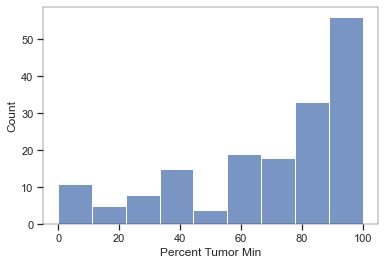

In [72]:
print(supp2_meth['Percent Tumor Min'].isna().sum())
sns.histplot(supp2_meth['Percent Tumor Min'])

print(supp2_meth.shape[0])
print((supp2_meth['Percent Tumor Min'] >= 40).sum())
print((supp2_meth['Percent Tumor Min'] >= 60).sum())
print((supp2_meth['Percent Tumor Min'] >= 70).sum())

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Percent Necrosis Max', ylabel='Count'>

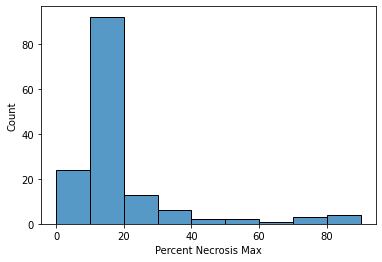

In [21]:
sns.histplot(supp2_meth['Percent Necrosis Max'])

## Concordance of clinicopathological data

In [354]:
a.rename(columns=lambda x:x.lower())

supp2,asian,black or african american,native hawaiian or other pacific islander,unknown,white
clinical,,,,,
Unknown,,,,19,
asian,2,,,,
black or african american,,30,,,
native hawaiian or other pacific islander,,,3,,
white,,,,,159


In [368]:
def concordanceTable(var_clinical, var_supp2):
    return pd.concat([
        clinical['TARGET'][var_clinical].rename('clinical'),
        supp2_meth[var_supp2].rename('supp2')
    ], axis=1).groupby('clinical')['supp2'].value_counts().unstack().fillna(0).astype(int).map(lambda x:str(x) if x > 0 else '').rename(index=lambda x:x.lower()).rename(columns=lambda x:x.lower()).sort_index(axis=0).sort_index(axis=1)

display(concordanceTable('race', 'Race'))
display(concordanceTable('inss_stage', 'INSS Stage'))
display(concordanceTable('inpc_grade', 'Grade'))
display(concordanceTable('cog_neuroblastoma_risk_group', 'COG Risk Group'))
display(concordanceTable('gender', 'Gender'))

(clinical['TARGET']['age_at_diagnosis'] == supp2_meth['Age at Diagnosis in Days']).all()

supp2,asian,black or african american,native hawaiian or other pacific islander,unknown,white
clinical,,,,,
asian,2,,,,
black or african american,,30,,,
native hawaiian or other pacific islander,,,3,,
unknown,,,,19,
white,,,,,159


supp2,stage 1,stage 2b,stage 3,stage 4,stage 4s
clinical,,,,,
stage 1,15,,,,
stage 2b,,1,,,
stage 3,,,6,,
stage 4,,,,167,
stage 4s,,,,,24


supp2,differentiating,undifferentiated or poorly differentiated,unknown
clinical,,,
differentiating,13,,
undifferentiated or poorly differentiated,,162,
unknown,,,38


supp2,high risk,intermediate risk,low risk
clinical,,,
high risk,168,,
intermediate risk,,14,
low risk,,,31


supp2,female,male
clinical,,
female,85,
male,,128


True

## Relapse data

In [376]:
has_relapse = ~supp2_meth['Site of Relapse'].isna()
print(has_relapse.sum())
print(clinical['TARGET']['progression_or_recurrence'].unique())

88
[nan]


In [377]:
has_relapse

submitter_id
TARGET-30-PANWRR     True
TARGET-30-PARETE     True
TARGET-30-PARSRJ     True
TARGET-30-PATGWT     True
TARGET-30-PASLGS    False
                    ...  
TARGET-30-PALZRG     True
TARGET-30-PASPBZ    False
TARGET-30-PASMDM    False
TARGET-30-PARNNC     True
TARGET-30-PARZHA    False
Name: Site of Relapse, Length: 213, dtype: bool

## Concordance of survival data

In [322]:
supp2_meth

,Gender,Race,Ethnicity,Age at Diagnosis in Days,First Event,Event Free Survival Time in Days,Vital Status,Overall Survival Time in Days,Year of Diagnosis,Year of Last Follow Up,...,COG Risk Group,Percent Tumor,Percent Necrosis,Percent Tumor v/s Stroma,Sites of Disease Involvement,Site of Relapse,Relapse Percent Tumor,Relapse Percent Necrosis,Relapse Percent Tumor v/s Stroma,Percent Tumor Min
submitter_id,,,,,,,,,,,,,,,,,,,,,
TARGET-30-PANWRR,Male,White,Not Hispanic or Latino,2937,Progression,267.0,Dead,345.0,2005,2006.0,...,High Risk,NaN,NaN,NaN,NaN,Lymph Nodes,NaN,NaN,NaN,NaN
TARGET-30-PARETE,Male,White,Not Hispanic or Latino,686,Progression,241.0,Dead,261.0,2007,2008.0,...,High Risk,40,30,40/60,NaN,Primary Site; Bone Marrow; Other Metastatic Sites,NaN,NaN,NaN,40.0
TARGET-30-PARSRJ,Male,White,Not Hispanic or Latino,1905,Relapse,1329.0,Alive,3225.0,2007,2016.0,...,High Risk,5,90,5/95,NaN,Bone,NaN,NaN,NaN,5.0
TARGET-30-PATGWT,Male,Black or African American,Not Hispanic or Latino,591,Relapse,727.0,Dead,928.0,2010,2012.0,...,High Risk,50,10,50/50,NaN,Bone; Lymph Nodes,NaN,NaN,NaN,50.0
TARGET-30-PASLGS,Male,Unknown,Not Hispanic or Latino,1218,Event,546.0,Dead,830.0,2009,2011.0,...,High Risk,80,10,80/20,NaN,NaN,NaN,NaN,NaN,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARGET-30-PALZRG,Female,White,Not Hispanic or Latino,577,Relapse,422.0,Dead,580.0,2002,2004.0,...,High Risk,75,25,90/10,NaN,"Other, specify: Lobular, large suprarenal mass...",NaN,NaN,NaN,75.0
TARGET-30-PASPBZ,Male,Black or African American,Not Hispanic or Latino,62,Censored,3434.0,Alive,3434.0,2009,2018.0,...,Intermediate Risk,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0
TARGET-30-PASMDM,Male,White,Not Hispanic or Latino,25,Censored,1324.0,Alive,1324.0,2009,2012.0,...,Low Risk,40,10,40/60,NaN,NaN,NaN,NaN,NaN,40.0


## MYC amplification status

In [29]:
clinical['TARGET'].drop('MYCN status', axis=1, inplace=True, errors='ignore')
clinical['TARGET'] = clinical['TARGET'].merge(supp2_meth['MYCN status'], left_index=True, right_index=True)
clinical['TARGET']['MYCN status'] = clinical['TARGET']['MYCN status'].map({'Amplified':'MYCN-amplified', 'Not Amplified':'MYCN-nonamplified'})
clinical['TARGET'].name = 'Discovery'

<Axes: ylabel='Tumor mitotic age'>

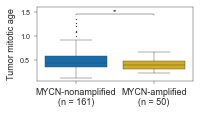

In [30]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'MYCN status', restrict=False,
                   var_y='phi', outfile=True, title=False, signif_bar_heights = 0.1,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age', file_format='svg',
                       outdir=covar_path_outdir, use_groups=['MYCN-nonamplified', 'MYCN-amplified'],
                   figsize=figsize * [1, 0.85], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

# Covariate Analysis with calendar age

<Axes: title={'center': 'Discovery'}, ylabel='Tumor age (years)'>

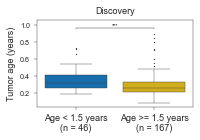

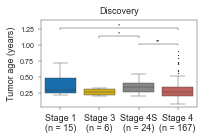

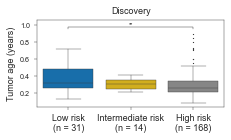

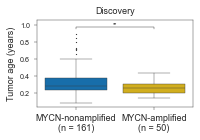

In [74]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'Age >= 1.5', restrict=True,
                   var_y='calendar_age_years', outfile=True, title=True, signif_bar_heights = 0.07,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor age (years)',
                       outdir=covar_path_outdir,
                   figsize=figsize, labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'inss_stage', restrict=True,
                   var_y='calendar_age_years', outfile=True, title=True, signif_bar_heights = 0.12,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor age (years)',
                       outdir=covar_path_outdir, use_groups=['Stage 1', 'Stage 3', 'Stage 4S', 'Stage 4'],
                   figsize=figsize, labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'cog_neuroblastoma_risk_group', restrict=True,
                   var_y='calendar_age_years', outfile=True, title=True, signif_bar_heights = 0.08,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor age (years)',
                       outdir=covar_path_outdir, use_groups=["Low risk", "Intermediate risk", "High risk"],
                   figsize=figsize * [1.2, 1], labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'MYCN status', restrict=False,
                   var_y='calendar_age_years', outfile=True, title=True, signif_bar_heights = 0.08,
                   palette=nbl_consts['palette_jco'], xlabel='', ylabel='Tumor age (years)',
                       outdir=covar_path_outdir, use_groups=['MYCN-nonamplified', 'MYCN-amplified'],
                   figsize=figsize, labelfontsize=nbl_consts['labelfontsize'] * 0.9, ticksfontsize=nbl_consts['ticksfontsize'], sf=sf, linewidth=nbl_consts['linewidth'], fliersize=nbl_consts['fliersize'])